<h1> Book Recommender <h1>
<h3> The focus of this project is to build a simple and straightforward Book Recommender using similarity as our driver for suggestions </h3>

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
book_rating_path = "/workspaces/ProjectPortfolio/1. Data Science/2. KNN - Book Recommender/Datasets/BX-Book-Ratings.csv"
book_path = "/workspaces/ProjectPortfolio/1. Data Science/2. KNN - Book Recommender/Datasets/BX-Books.csv"
book_user_path = "/workspaces/ProjectPortfolio/1. Data Science/2. KNN - Book Recommender/Datasets/BX-Users.csv"


book_rating_df = pd.read_csv(
    book_rating_path,
    encoding = "ISO-8859-1",
    sep=";")

book_df = pd.read_csv(
    book_path,
    encoding = "ISO-8859-1",
    sep=";",
    on_bad_lines="skip")

book_user_df = pd.read_csv(
    book_user_path,
    encoding = "ISO-8859-1",
    sep=";")

In [4]:
book_rating_df.head()


,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
book_rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [5]:
book_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [6]:
book_user_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [7]:
book_merged_df = pd.merge(book_rating_df, book_user_df, on='User-ID', how='inner')
book_merged_df = pd.merge(book_merged_df, book_df, on='ISBN', how='inner')

book_merged_df.head()

,User-ID,ISBN,Book-Rating,Location,Age,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,"tyler, texas, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,2313,034545104X,5,"cincinnati, ohio, usa",23.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
2,6543,034545104X,0,"strafford, missouri, usa",34.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
3,8680,034545104X,5,"st. charles county, missouri, usa",2.0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
4,10314,034545104X,9,"beaverton, oregon, usa",NaN,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...


In [56]:
book_rating_df.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [18]:
book_rating_df['Book-Rating'].value_counts()

Book-Rating
0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: count, dtype: int64

<h4> Since this dataset is non-null I will assume that any zero rating will count as a non-rated book and will thus be exluded from the dataset </h4>

In [48]:
book_rating_clean_df = book_rating_df[book_rating_df['Book-Rating']>0]

<h3><b> Personal Note:</b> </h3>
<h4> Based on value counts and the histogram below, the distribution is left-skewed (negatively skewed).</h4>
<h5>I was actually anticipating more of a inverted bell curve or un-bell curve since I've noticed people tend to rate and review items when they feel strongly towards the item either negatively or positivly. <br>
My example for this is Amazon reviews for items. Often they will have a high count of 1 and 5 star reviews with a drop off in count between the two extremes. <br>
In this case, people tend to rate more favourably with a 5 rating being the drop-off point. </h5>

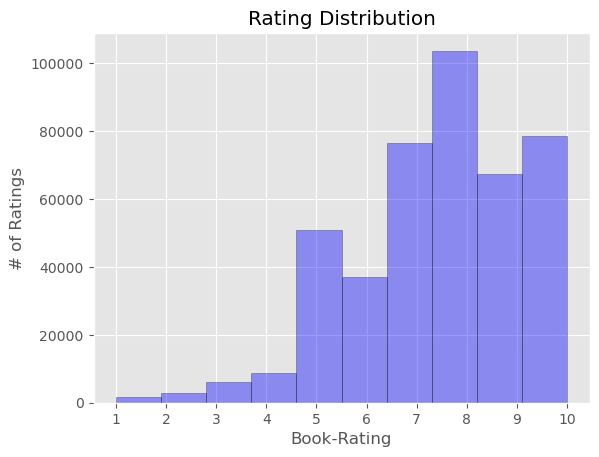

In [55]:
sns.distplot(book_rating_clean_df['Book-Rating'], hist=True, kde=False, hist_kws={'edgecolor': 'black'}, kde_kws={'linewidth': 2},bins=10,
             color='blue')
plt.title("Rating Distribution")
plt.ylabel("# of Ratings")
plt.xticks(np.arange(1, 11, 1))
plt.show()

In [64]:
book_rating_clean_df

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [69]:
from scipy.sparse import csr_matrix

book_rating_matrix = csr_matrix(pd.crosstab(index=book_rating_clean_df['ISBN'],
                                            columns=book_rating_clean_df['User-ID'],
                                            values=book_rating_clean_df['Book-Rating'],
                                            aggfunc='first'))

book_rating_matrix.head(5)

MemoryError: Unable to allocate 13.5 GiB for an array with shape (14469629265,) and data type bool